In [5]:
import requests
import zipfile
import io
import glob
import os
from typing import Final, Type, Dict, Literal
import datetime as dt

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import numpy as np


from data_load import DataCatalog, DataCatalogEntry

import constants as const

## Constants & Assumptions

In [6]:
data_catalog = DataCatalog.load_from_yaml()
ons_dfs = data_catalog.scenario_data_sources[0].load()


In [11]:



class ONSPopulationScenario:



    def __init__(self, ons_catalog_entry: Type[DataCatalogEntry]):
        self.ons_catalog_entry = ons_catalog_entry
        self.ons_raw_df:pd.DataFrame = self.ons_catalog_entry.load()
        self.interpolated_df:pd.DataFrame = pd.DataFrame()
        self.yearly_age_bins = '5'
        self.time_period = 'daily'
        self.name = self.ons_catalog_entry.name
    
    def interpolated_population(self, time_period: Literal['daily','monthly','yearly'] = 'daily', yearly_age_bins:Literal[None,'5','10','Total'] = '5'):
        """
        Returns the population for a given sub_icb, age_group and date.
        """

        if not self.interpolated_df.empty and self.time_period == time_period and self.yearly_age_bins == yearly_age_bins:
            # return cached df
            return self.interpolated_df.copy()
        self.yearly_age_bins = yearly_age_bins
        self.time_period = time_period
        df = self.ons_raw_df.copy()
        # create sub-icb column and drop na, drop
        df = df.assign(sub_icb = lambda df: df['AREA_NAME'].map(const.CCG_SUB_ICB)).dropna()
        if yearly_age_bins != 'Total' or yearly_age_bins is None:
            # Drop 'All ages' in AGE_GROUP
            df = df.loc[df['AGE_GROUP'] != 'All ages']
        # Create bins and labels for age groups
        if yearly_age_bins == '5':
            bins = [i for i in range(0,91,5)] + [150]
            labels = [f'{i}-{i+4}' for i in range(0,90,5)] + ['90+']
        elif yearly_age_bins == '10':
            bins = [i for i in range(0,91,10)] + [150]
            labels = [f'{i}-{i+9}' for i in range(0,90,10)] + ['90+']
        # Replace '90 and over' with 90 and convert to int
        if yearly_age_bins == '5' or yearly_age_bins == '10':
            df['AGE_GROUP'] = df['AGE_GROUP'].replace("90 and over", 90).astype(int)
            # Create age groups
            df['AGE_GROUP'] = pd.cut(df['AGE_GROUP'], bins, labels = labels,include_lowest = True, right = False)
        # unpivot table
        df = df.drop(columns={'AREA_CODE','COMPONENT','SEX','AREA_NAME'}).melt(id_vars=['AGE_GROUP','sub_icb'], var_name='year', value_name='population')
        # convert year to datetime
        df['year'] = df['year'].astype(int) 
        df['Date'] = pd.to_datetime(df['year'].astype(str) + '-01-01')
        # drop year column
        df = df.drop(columns={'year'})
        # convert population to int
        df['population'] = df['population'].astype(int)
        # group by age group, date and sub_icb
        df= df.groupby(['AGE_GROUP','Date','sub_icb']).sum().reset_index()
        # interpolate
        df = self._interpolate_subpopulations(df, 'sub_icb', 'AGE_GROUP', time_period=time_period)
        self.interpolated_df = df.copy()
        return df

    @staticmethod
    def _interpolate_subpopulations(df_:pd.DataFrame, cat_col_1:str ='sub_icb', cat_col_2:str='AGE_GROUP', time_period: Literal['daily','monthly','yearly'] = 'daily')->pd.DataFrame:
        """Interpolates the population for a given sub_icb, age_group and date.

        Args:
            df_ (pd.DataFrame): input dataframe
            cat_col_1 (str): 1st categorical column
            cat_col_2 (str): 2nd categorical column

        Returns:
            pd.DataFrame: interpolated dataframe
        """

        aggregations ={
            'daily': 'D',
            'monthly': 'MS'}
        if time_period == 'yearly':
            return df_
       
        agg_period = aggregations.get(time_period, 'D')
        cat_col_1_vals = df_[cat_col_1].unique()
        cat_col_2_vals = df_[cat_col_2].unique()
        sub_dfs = []
        for cat1 in cat_col_1_vals:
            for cat2 in cat_col_2_vals:
                sub_df = df_.loc[(df_[cat_col_1] == cat1) & (df_[cat_col_2] == cat2)].set_index(['Date']).drop(columns=[cat_col_1, cat_col_2])
                sub_df = sub_df.resample(agg_period).interpolate(method='linear', fill_value=0.0).round(0).astype(int).reset_index()
                sub_df[cat_col_1] = cat1
                sub_df[cat_col_2] = cat2
        
                sub_dfs.append(sub_df)
        agg_df = pd.concat(sub_dfs)
        return agg_df

In [12]:
ons_pop = ONSPopulationScenario(data_catalog.scenario_data_sources[0].scenarios[0])

In [14]:
ons_pop.interpolated_population(time_period='monthly', yearly_age_bins='10')['Date'].unique()

/tmp/ipykernel_19947/1573992165.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df= df.groupby(['AGE_GROUP','Date','sub_icb']).sum().reset_index()


<DatetimeArray>
['2018-01-01 00:00:00', '2018-02-01 00:00:00', '2018-03-01 00:00:00',
 '2018-04-01 00:00:00', '2018-05-01 00:00:00', '2018-06-01 00:00:00',
 '2018-07-01 00:00:00', '2018-08-01 00:00:00', '2018-09-01 00:00:00',
 '2018-10-01 00:00:00',
 ...
 '2042-04-01 00:00:00', '2042-05-01 00:00:00', '2042-06-01 00:00:00',
 '2042-07-01 00:00:00', '2042-08-01 00:00:00', '2042-09-01 00:00:00',
 '2042-10-01 00:00:00', '2042-11-01 00:00:00', '2042-12-01 00:00:00',
 '2043-01-01 00:00:00']
Length: 301, dtype: datetime64[ns]

In [80]:
ons_pop.create_daily_population()

/tmp/ipykernel_3154/454043127.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df= df.groupby(['AGE_GROUP','Date','sub_icb']).sum().reset_index()


,AGE_GROUP,Date,sub_icb,population
0,0-9,2018-01-01,Ipswich & East Suffolk,45340
1,0-9,2018-01-01,North East Essex,38656
2,0-9,2018-01-01,West Suffolk,27444
3,0-9,2019-01-01,Ipswich & East Suffolk,44847
4,0-9,2019-01-01,North East Essex,38811
...,...,...,...,...
775,90+,2042-01-01,North East Essex,7167
776,90+,2042-01-01,West Suffolk,6744
777,90+,2043-01-01,Ipswich & East Suffolk,11050
778,90+,2043-01-01,North East Essex,7253


In [67]:
ONSDailyPopulationScenario.ons_raw_df

AttributeError: type object 'ONSDailyPopulationScenario' has no attribute 'ons_raw_df'

In [57]:
def interpolate_multi_index_df(df, cat_col_1:str, cat_col_2:str):
    cat_col_1_vals = df[cat_col_1].unique()
    cat_col_2_vals = df[cat_col_2].unique()
    sub_dfs = []
    for cat1 in cat_col_1_vals:
        for cat2 in cat_col_2_vals:
            sub_df = df.loc[(df[cat_col_1] == cat1) & (df[cat_col_2] == cat2)].set_index(['Date']).drop(columns=[cat_col_1, cat_col_2])
            sub_df = sub_df.resample('D').interpolate(method='linear', fill_value=0.0).round(0).astype(int).reset_index()
            sub_df[cat_col_1] = cat1
            sub_df[cat_col_2] = cat2
    
            sub_dfs.append(sub_df)

    return pd.concat(sub_dfs, axis=0)

,Date,population,sub_icb,AGE_GROUP
0,2018-01-01,45340,Ipswich & East Suffolk,0-9
1,2018-01-02,45339,Ipswich & East Suffolk,0-9
2,2018-01-03,45337,Ipswich & East Suffolk,0-9
3,2018-01-04,45336,Ipswich & East Suffolk,0-9
4,2018-01-05,45335,Ipswich & East Suffolk,0-9
...,...,...,...,...
9127,2042-12-28,6822,West Suffolk,90+
9128,2042-12-29,6822,West Suffolk,90+
9129,2042-12-30,6823,West Suffolk,90+
9130,2042-12-31,6823,West Suffolk,90+


In [57]:
ons_df[]

(Timestamp('2018-01-01 00:00:00'), 'Ipswich & East Suffolk', '0-9')

In [52]:
pd.date_range(start='2018-01-01',end='2044-01-01', freq='D')

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2043-12-23', '2043-12-24', '2043-12-25', '2043-12-26',
               '2043-12-27', '2043-12-28', '2043-12-29', '2043-12-30',
               '2043-12-31', '2044-01-01'],
              dtype='datetime64[ns]', length=9497, freq='D')

In [ ]:
daily_ons_df = ons_df.copy().drop(columns=['AREA_CODE','AREA_NAME','COMPONENT','SEX','WorkingAge']).melt(id_vars=['SUB_ICB','AGE_GROUP'], value_name='population', var_name='year')
daily_ons_df['date'] = pd.to_datetime(daily_ons_df['year'].map(lambda x: f"{str(x)}-01-01"))

In [ ]:
daily_ons_df

,SUB_ICB,AGE_GROUP,year,population,date
0,North East Essex,0,2018,2214.000,2018-01-01
1,North East Essex,1,2018,2207.000,2018-01-01
2,North East Essex,2,2018,2297.000,2018-01-01
3,North East Essex,3,2018,2372.000,2018-01-01
4,North East Essex,4,2018,2345.000,2018-01-01
...,...,...,...,...,...
19131,Ipswich & East Suffolk,87,2043,1245.632,2043-01-01
19132,Ipswich & East Suffolk,88,2043,1106.856,2043-01-01
19133,Ipswich & East Suffolk,89,2043,1006.773,2043-01-01
19134,Ipswich & East Suffolk,90 and over,2043,4694.958,2043-01-01


In [ ]:
daily_frame = pd.DataFrame(index=pd.date_range(daily_ons_df['date'].iloc[0],daily_ons_df['date'].iloc[-1]))
daily_ons_df.set_index('date').reindex(daily_frame.index)


<ipython-input-55-d291867f2d9d>:2: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  daily_ons_df.set_index('date').reindex(daily_frame.index)


ValueError: ignored

In [ ]:
daily_ons_df = daily_ons_df.asfreq('D')

<ipython-input-45-8da9d32a0a4c>:1: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  daily_ons_df = daily_ons_df.asfreq('d')


ValueError: ignored

In [ ]:
daily_ons_df.

### Total population

<Axes: >

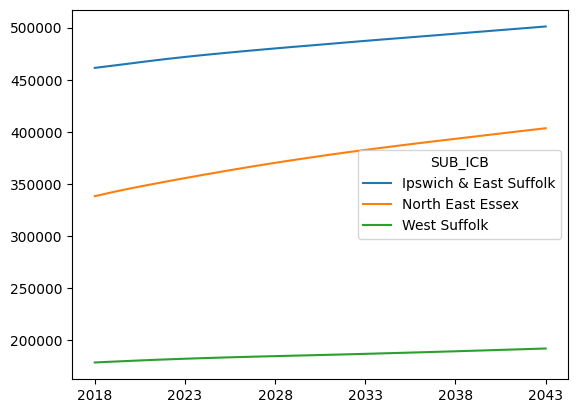

In [ ]:
ons_total_df = ons_df.loc[ons_df['AGE_GROUP']=='All ages']
ons_total_df.groupby('SUB_ICB').sum(numeric_only=True).T.plot()

In [ ]:
def calc_oadr_status(ons_age_group:str):
    ons_age_group = ons_age_group.replace(" and over", "")
    try:
        ons_age = int(ons_age_group)
    except ValueError:
        return None
    if ons_age < 65 and ons_age >=20:
        return 'Working'
    elif ons_age >=65:
        return 'Retired'
    else:
        return None



In [ ]:
ons_df['WorkingAge'] = ons_df['AGE_GROUP'].map(calc_oadr_status)

<Axes: >

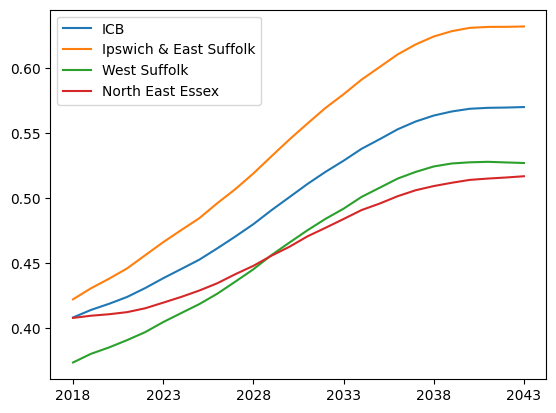

In [ ]:
oadr_df = ons_df.groupby(['WorkingAge']).sum(numeric_only=True).T
oadr_df['ICB'] = oadr_df['Retired']/  oadr_df['Working']
sub_icb_oadrs = [oadr_df['ICB']]
for sub_icb in SUB_ICB_CODES.values():
    sub_icb_df = ons_df.loc[ons_df['SUB_ICB']==sub_icb].copy()
    sub_icb_df = sub_icb_df.groupby(['WorkingAge']).sum(numeric_only=True).T
    sub_icb_oadr = sub_icb_df['Retired']/  sub_icb_df['Working']
    sub_icb_oadr.name = sub_icb
    sub_icb_oadrs.append(sub_icb_oadr)
oadr_df = pd.concat(sub_icb_oadrs, axis=1)
oadr_df.plot()




In [ ]:
sub_icb_df

WorkingAge,Retired,Working
2018,76238.000,186829.000
2019,77356.630,188790.905
2020,78306.862,190585.112
2021,79268.343,192163.862
2022,80323.446,193341.481
2023,81579.698,194338.562
2024,82891.447,195408.651
2025,84254.733,196359.172
2026,85760.852,197284.009
2027,87461.297,198027.157


In [ ]:
print(sorted(ons_df['AREA_NAME'].unique()))

['Babergh', 'Colchester', 'Forest Heath', 'Ipswich', 'Mid Suffolk', 'St Edmundsbury', 'Suffolk Coastal', 'Tendring']


In [ ]:
snee_df= snee_df.set_index(['APPOINTMENT_MONTH','Sub ICB Area'])

In [ ]:
import calendar
import numpy as np
import datetime as dt

def get_numdays(df_:pd.DataFrame):
    month_values = df_.index.get_level_values('APPOINTMENT_MONTH')
    years, months =  month_values.year, month_values.month

    def _num_days_in_month(year:int, month:int):
        # to be used by np.vectorize
        return calendar.monthrange(year, month)[1]

    num_days_in_month_v_ = np.vectorize(_num_days_in_month)

    return num_days_in_month_v_(years,months)

def get_workingdays(a_:np.array):
    years, months =  a_.year, a_.month

    #
    def _num_workingdays_in_month(year,month):
        workingdays = 0
        day = 1
        while day <= calendar.monthrange(year,month)[1]:
            the_date =  dt.datetime(year,month,day)
            if the_date.isoweekday() and the_date not in ENGLAND_BANK_HOLIDAYS:
                workingdays +=1
            day += 1
        return workingdays

    vec_workingdays = np.vectorize(_num_workingdays_in_month)
    return vec_workingdays(years, months)

snee_df['num_days_in_month'] = get_numdays(snee_df)
snee_df['num_workingdays_in_month'] = get_workingdays(snee_df.index.get_level_values('APPOINTMENT_MONTH'))


total_appts = (snee_df
               .groupby(['Sub ICB Area','APPOINTMENT_MONTH'])
               .sum(numeric_only=True)
               .reset_index()
               .pivot(columns='Sub ICB Area', index='APPOINTMENT_MONTH',values='COUNT_OF_APPOINTMENTS')
               )

KeyError: ignored

In [ ]:
snee_df['Appointments/day'] = snee_df['COUNT_OF_APPOINTMENTS'] / snee_df['num_days_in_month']
snee_df['Appointments/working day'] = snee_df['COUNT_OF_APPOINTMENTS'] / snee_df['num_days_in_month']

In [ ]:
snee_appt_df = snee_df.reset_index().pivot_table(values=['Appointments/day'], index='APPOINTMENT_MONTH', columns='Sub ICB Area', aggfunc='sum')

In [ ]:
snee_appt_df.plot()

In [ ]:
fig, axes = plt.subplots(nrows=3,ncols=1, figsize=(15,20))
for plot_i, sub_icb in enumerate(snee_df.index.get_level_values('Sub ICB Area').unique()):
    # slice by icb
    sub_icb_df = snee_df.loc[snee_df.index.get_level_values('Sub ICB Area') == sub_icb].copy().reset_index()
    appts_workingday = sub_icb_df.groupby('APPOINTMENT_MONTH')['Appointments/working day'].sum()
    axes[plot_i].scatter(x=appts_workingday.index,y=appts_workingday.values, label='mean appointments/working day', marker='.', alpha=0.4, color='red')
    # appts_day = sub_icb_df.groupby('APPOINTMENT_MONTH')['Appointments/day'].sum()
    # axes[plot_i].scatter(x=appts_day.index, y=appts_day.values, label="mean appointments/day")
    appts_total= sub_icb_df.groupby('APPOINTMENT_MONTH')['COUNT_OF_APPOINTMENTS'].sum()
    second_ax = axes[plot_i].twinx()
    second_ax.plot(appts_total,label='Total appointments')
    if plot_i == 2:
        axes[plot_i].legend(ncols=3)
    axes[plot_i].set_title(sub_icb)
plt.tight_layout()
plt.show()






In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10))
total_appts.plot.area(ax=ax)
ax.set_title('Total Appointments in SNEE ICB')

In [ ]:
from numba.stencils.stencil import lower_builtin

from enum import Enum
from dataclasses import dataclass













In [ ]:
distribution of time taken, for each staff type, for each appointment type, for each ICB
needs

STAFF_PROBABILITY = {"GP":float(1/3), "Nurse":float(3/6), "AHP": float(1/6) }


In [ ]:
import random

In [ ]:
random.choices(list(staffs.keys()), weights=list(staffs.values()))

In [ ]:
snee_df.groupby(['HCP_TYPE','APPT_MODE'])['COUNT_OF_APPOINTMENTS'].count()

In [ ]:
from ast import literal_eval

In [ ]:
eval("float(1/4)")